##Import Modules

In [ ]:
# import libraries
import os # Handeling the file
import pickle #primarily used in serializing and deserializing a Python object structure
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm #used for creating Progress Meters or Progress Bars

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input # preprocess any image to extract the features from image
from tensorflow.keras.preprocessing.image import load_img, img_to_array 
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences # Even out the whole text representaion of features for the remaining length.
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical,plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout,add

from nltk.translate.bleu_score import corpus_bleu # Bleu score

import cv2
from google.colab.patches import cv2_imshow


import pdb #python debugger



import matplotlib.pyplot as plt
from PIL import Image


##Import dataset from kaggle

In [ ]:
os.environ['KAGGLE_CONFIG_DIR']='/content/drive/MyDrive/Kaggle_dataset/Flicker30k'

In [ ]:
%cd /content/drive/MyDrive/Kaggle_dataset/Flicker30k

/content/drive/MyDrive/Kaggle_dataset/Flicker30k


In [ ]:
!ls

kaggle.json


In [ ]:
!kaggle datasets download -d adityajn105/flickr30k

100% 8.15G/8.16G [01:15<00:00, 80.8MB/s]
100% 8.16G/8.16G [01:15<00:00, 116MB/s] 


##Unzip Data files

In [ ]:
from zipfile import ZipFile
file='/content/drive/MyDrive/Kaggle_dataset/Flicker30k/flickr30k.zip'
with ZipFile(file,'r') as zip:
  zip.printdir()
  print('processing...........')
  zip.extractall('/content/drive/MyDrive/Kaggle_dataset/Flicker30k/')
  print("Process completed!")

Streaming output truncated to the last 5000 lines.
Images/5914327.jpg                             2020-04-27 08:19:44        45548
Images/5914778546.jpg                          2020-04-27 08:19:44       196262
Images/5914789066.jpg                          2020-04-27 08:19:44       128365
Images/5915534813.jpg                          2020-04-27 08:19:44       141218
Images/5916878545.jpg                          2020-04-27 08:19:44       125723
Images/5918675.jpg                             2020-04-27 08:19:44        40447
Images/5918840.jpg                             2020-04-27 08:19:44        65378
Images/5919020.jpg                             2020-04-27 08:19:44        61733
Images/5920741851.jpg                          2020-04-27 08:19:44       153300
Images/59209034.jpg                            2020-04-27 08:19:44       128592
Images/5921176217.jpg                          2020-04-27 08:19:44       193927
Images/5921223189.jpg                          2020-04-27 08:19:44   

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Streaming output truncated to the last 5000 lines.
Images/flickr30k_images/5356236664.jpg         2020-04-27 08:26:40       112048
Images/flickr30k_images/5356318668.jpg         2020-04-27 08:26:40       162652
Images/flickr30k_images/535830521.jpg          2020-04-27 08:26:40       135648
Images/flickr30k_images/5359437945.jpg         2020-04-27 08:26:40       159557
Images/flickr30k_images/5361355399.jpg         2020-04-27 08:26:40        94812
Images/flickr30k_images/53614287.jpg           2020-04-27 08:26:40        95983
Images/flickr30k_images/536147209.jpg          2020-04-27 08:26:40       127725
Images/flickr30k_images/5361551308.jpg         2020-04-27 08:26:40       170899
Images/flickr30k_images/536156200.jpg          2020-04-27 08:26:40       126913
Images/flickr30k_images/5362687336.jpg         2020-04-27 08:26:40       168559
Images/flickr30k_images/5363528971.jpg         2020-04-27 08:26:40       103433
Images/flickr30k_images/5363903246.jpg         2020-04-27 08:26:42   

##Set the Directories

In [ ]:
# Set directories
BASE_DIR='/content/drive/MyDrive/Kaggle_dataset/Flicker30k/'
WORKING_DIR='/content/drive/MyDrive/Colab Notebooks/Image captioning using flicker/'


##VGG16 Model using ImageNet 

In [ ]:
#import vgg16 model
vgg_model=VGG16(weights='imagenet')
#re-structure the model by removing last 2 layers
vgg_model.layers.pop()
vgg_model=Model(inputs=vgg_model.inputs, outputs=vgg_model.layers[-2].output) ##Dropping last 2 layers

553476096/553467096 [==============================] - 8s 0us/step


In [ ]:
#summarize
print(vgg_model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

##Load Image data

In [ ]:
# Load data using os.path.join and os.listdir function
#directory=os.path.join(BASE_DIR,'Images')
#path=os.listdir(directory)
#print(path)

#Load path of data using glob 
import glob
path=glob.glob('/content/drive/MyDrive/Kaggle_dataset/flickr8k/Images/*.jpg')
print(len(path))

8091


In [ ]:
## Image visualization
for i in range(5):
  img=cv2.imread(path[i])
  cv2_imshow(img)

Output hidden; open in https://colab.research.google.com to view.

##Extract Image Features

In [ ]:
#extract features from image
features={}
#count=0
for img_name in tqdm(path):
 #load the images from Images folder
  img_file=cv2.imread(img_name)
  #resize data for model 
  img_file=cv2.resize(img_file,(224,224))
  #convert the image pixel to a numpy array
  X=image.img_to_array(img_file)
  #Reshape data for preprocess
  X=X.reshape((1,X.shape[0],X.shape[1],X.shape[2]))
  #y_file=np.expand_dims(x_file,axis=0)
  #y_file=x_file.reshape(1,224,224,3)

  #preprocess image for feature extraction
  X=preprocess_input(X)
  #get features
  feature=vgg_model.predict(X,verbose=0).reshape(4096,)
  #Get image ID
  image_id=((os.path.basename(img_name)).split('.')[0])
  
  #Store features
  features[image_id]=feature

  #Only get fix count of data
  #count +=1
  #if count>100:
    #break


  0%|          | 0/8091 [00:00<?, ?it/s]

In [ ]:
#Store featues in pickle
pickle.dump(features,open(os.path.join(WORKING_DIR,'features.pk'),'wb'))

##Load the Captions Data

In [ ]:
with open(os.path.join(BASE_DIR,'captions.txt'),'rb') as f:
  next(f) # To remove 1st line "Image, captions"
  Cap_doc=f.read().decode('utf-8').split('\n')
Cap_doc[:10]

['1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .',
 '1000268201_693b08cb0e.jpg,A girl going into a wooden building .',
 '1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .',
 '1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .',
 '1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .',
 '1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting',
 '1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with each other on the road .',
 '1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots are staring at each other in the street .',
 '1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each other on the road .',
 '1001773457_577c3a7d70.jpg,Two dogs on pavement moving toward each other .']

In [ ]:
mapping={}

for line in tqdm(Cap_doc):
  #pdb.set_trace()
  #split line by whit space
  tokens=line.split(',')
  if len(line)<1:
    continue
  # Take the 1st token as the image id and the rest as the description
  image_id,image_desc=tokens[0],tokens[1:]
  # Remove filename from image id
  image_id=(image_id.split('.')[0])
  #onvert description tokens back to string
  image_desc=''.join(image_desc)
  #print(image_desc)
  #create list if needed
  if image_id not in mapping:
    mapping[image_id]=list()
    #mapping[image_id]=[]
  #store description
  mapping[image_id].append(image_desc) 


  0%|          | 0/40456 [00:00<?, ?it/s]

##Preprocess text data

In [ ]:
# ceate a "Cleanup" function in separate file named "text_cleanup" and saved it in the same working directory as".py" and upload it for function call
from google.colab import files
files.upload()
#Cleanup(mapping)

Saving text_cleanup.py to text_cleanup.py


{'text_cleanup.py': b'# -*- coding: utf-8 -*-\n"""Text_Cleanup.ipynb\n\nAutomatically generated by Colaboratory.\n\nOriginal file is located at\n    https://colab.research.google.com/drive/1-Wa5lJbmpLpBOzPAGVOldbIiKyCbzXsT\n"""\n\ndef Cleanup(mapping):\n  import re\n  for key, captions in mapping.items():\n    for i in range(len(captions)):\n      #take one cations at a time\n      caption=captions[i]\n      #convert to lowercase\n      caption=caption.lower()\n      #deleate digits,special chars\n      caption=caption.replace(\'[^A-Za-z]\', \'\')\n      #delete addinional spaces\n      caption=caption.replace(\'\\s+\', \' \')\n      #Remove punctuations\n      caption = re.sub(r\'[^\\w\\s]\', \'\', caption)\n      #add start and end tags to the cation\n      caption=\'startseq \'+ \' \'.join([word for word in caption.split() if len(word)>1]) +\' endseq\'\n      captions[i]=caption\n  return'}

In [ ]:
#Call Cleanup Function from text_cleanup file
import text_cleanup
text_cleanup.Cleanup(mapping)

In [ ]:
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [ ]:
#Save cleanedup Maping file
pickle.dump(mapping,open(os.path.join(WORKING_DIR,'Mapping.txt'),'wb'))

##Load Saved Image features and Text Features for further process

In [ ]:
#Loading Image features from pickle
with open(os.path.join(WORKING_DIR,'features.pk'),'rb') as f:
  Img_features=pickle.load(f)
len(Img_features)

8091

In [ ]:
#Load the saved text file
with open(os.path.join(WORKING_DIR,'Mapping.txt'),'rb') as f:
  Mapping=pickle.load(f)
len(Mapping)

8091

In [ ]:
all_captions=[]
for key in Mapping:
  for caption in Mapping[key]:
    all_captions.append(caption)
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tricolored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [ ]:
#Max length of thhe caption available
max_length_cap=max(len(caption.split())for caption in all_captions)
max_length_cap

34

##Vocabulary dictionary 

In [ ]:
# tokenize the text 
tokenizer=Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_dict=tokenizer.word_index
vocab_size=len(vocab_dict)+1 # total number of unique word
vocab_size

8811

##Train-Test split

In [ ]:
#Train test split
image_ids=list(Mapping.keys())
split=int(len(image_ids)*0.9)
train_id=image_ids[:split]
print(len(train_id))
#Train_id chunk 
train_id_1=train_id[:2500]
train_id_2=train_id[2500:5000]
train_id_3=train_id[5000:]

test_id=image_ids[split:]
print(len(train_id_1),len(train_id_2),len(train_id_3))

7281
2500 2500 2281


##Data generator

In [ ]:
def data_generator(data_keys,features,mapping,tokenizer,max_length,vocab_size,batch_size):
  X1,X2,y=[],[],[]
  n=0
  while 1:
    for key in data_keys:
      #print(key)
      n+=1
      captions=mapping[key]
      #print(captions)
      #process each captions
      for caption in captions:
        #encode the sequences
        seq=tokenizer.texts_to_sequences([caption])[0]
        #print(seq)
        #spli sequence into X,y pairs
        for i in range(1,len(seq)):
          #print(seq[i])
          #Split into input and output pairs
          in_seq,out_seq=seq[:i],seq[i]
          #print(in_seq,out_seq)
          #pad input seq
          in_seq=pad_sequences([in_seq],maxlen=max_length)[0]
          #encode output seq
          out_seq=to_categorical([out_seq],num_classes=vocab_size)[0]
          #print(in_seq)
          #print(out_seq)
          #store the seq
          X1.append(features[key])
          X2.append(in_seq)
          y.append(out_seq)
          #print(len(X1),len(X2),len(y))
          #print('X1:',X1)
          #print('X2:',X2)
          #print('y:',y)
      if n==batch_size:
        X1=np.array(X1)
        X2=np.array(X2)
        y=np.array(y)
        #print(X1.shape,X2.shape,y.shape)
        yield [X1,X2],y
        X1,X2,y=[],[],[]
        n=0

##Model creation

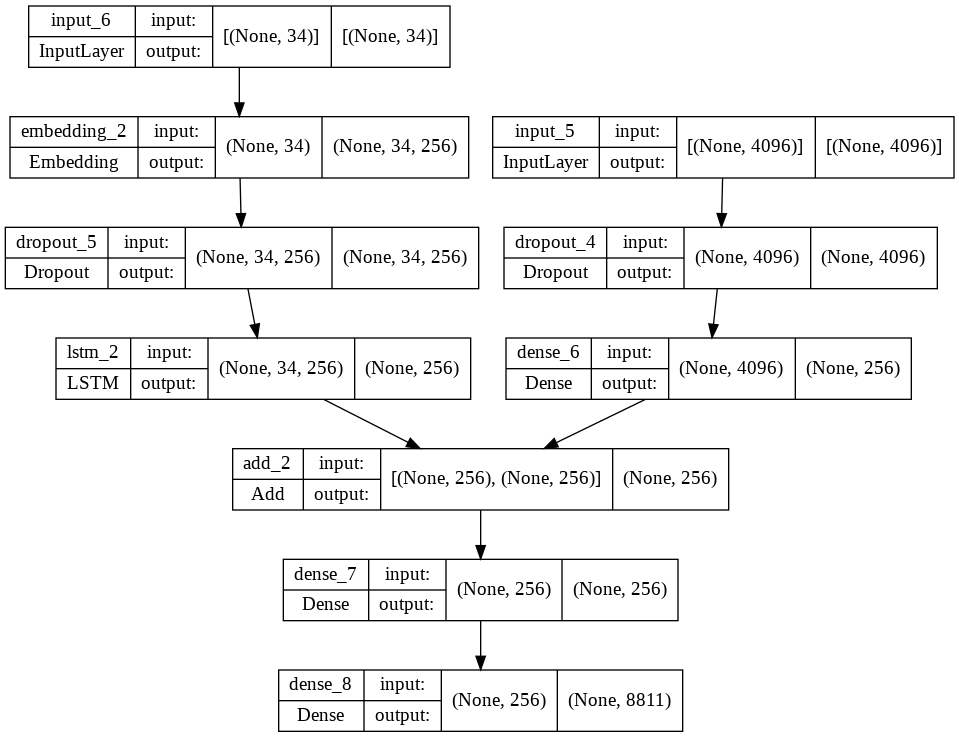

In [ ]:
#Encoder model
#image Feature layers
inputs1=Input(shape=(4096,))
Features1=Dropout(0.4)(inputs1)
Features2=Dense(256,activation='relu')(Features1)
#Text features layers
inputs2=Input(shape=(max_length_cap,))
seq1=Embedding(vocab_size,256,mask_zero=True)(inputs2)
seq2=Dropout(0.4)(seq1)
seq3=LSTM(256)(seq2)

#Decoder Model
decoder1=add([Features2,seq3])
decoder2=Dense(256,activation='relu')(decoder1)
outputs=Dense(vocab_size,activation='softmax')(decoder2)

model=Model(inputs=[inputs1,inputs2],outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

#plot the model
plot_model(model,show_shapes=True)

##Fit the model for trainning

In [ ]:
## Train model for total 55 epoch
epochs=15
batch_size=64
steps=(len(train_id)//batch_size)
for i in tqdm(range(epochs)):
  print('Epoch: ',i)
  generator=data_generator(train_id,Img_features,Mapping,tokenizer,max_length_cap,vocab_size,batch_size)

  new_model.fit(generator,epochs=1,steps_per_epoch=steps,shuffle=True,verbose=1)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch:  0
113/113 [==============================] - 70s 569ms/step - loss: 1.8709 - accuracy: 0.5032
Epoch:  1
113/113 [==============================] - 62s 545ms/step - loss: 1.8571 - accuracy: 0.5061
Epoch:  2
113/113 [==============================] - 62s 545ms/step - loss: 1.8418 - accuracy: 0.5078
Epoch:  3
113/113 [==============================] - 61s 541ms/step - loss: 1.8295 - accuracy: 0.5108
Epoch:  4
113/113 [==============================] - 61s 540ms/step - loss: 1.8156 - accuracy: 0.5136
Epoch:  5
113/113 [==============================] - 61s 536ms/step - loss: 1.8073 - accuracy: 0.5158
Epoch:  6
113/113 [==============================] - 61s 536ms/step - loss: 1.7942 - accuracy: 0.5178
Epoch:  7
113/113 [==============================] - 61s 539ms/step - loss: 1.7868 - accuracy: 0.5190
Epoch:  8
113/113 [==============================] - 61s 538ms/step - loss: 1.7746 - accuracy: 0.5218
Epoch:  9
113/113 [==============================] - 61s 539ms/step - loss: 1.7651

In [ ]:
#save the model
new_model.save(WORKING_DIR+'/best_model3.h5')

In [ ]:
#Load the model
from tensorflow import keras
# Recreate the exact same model, including its weights and the optimizer
new_model = keras.models.load_model(WORKING_DIR+'/best_model3.h5')

# Show the model architecture
new_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 34)]         0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 4096)]       0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 34, 256)      2255616     ['input_6[0][0]']                
                                                                                                  
 dropout_4 (Dropout)            (None, 4096)         0           ['input_5[0][0]']                
                                                                                            

##Prediction

In [ ]:
#Generate captions for images
#Index to word
def idx_to_word(integer,tokenizer):
  for word,index in tokenizer.word_index.items():
    if index==integer:
      return word
  return None

In [ ]:
#Generate caption for an image
def predict_caption(model,image,tokenizer,max_length):
  #in_text=[]
  #Add start tag for generation process
  in_text='startseq'
  #Iterate over the max length of sequence 34
  for i in range(1,max_length):
    #pdb.set_trace()
    #encode input seq
    seq=tokenizer.texts_to_sequences([in_text])[0]
    #padding
    seq=pad_sequences([seq],max_length)
    #print(seq)
    #predict next word
    y_next=model.predict([image,seq],verbose=0)
    #print(y_next)
    #get index with high probability
    y_next=np.argmax(y_next)
    #print(y_next)
    #convert index to word
    word=idx_to_word(y_next,tokenizer)
    #stop if word not found
    if word is None:
      break
    #append word as input for generating next word
    in_text+= " "+word
    #stop if we rich end tag
    if word=='endseq':
      break
  return in_text


In [ ]:
test_id1=test_id[:10]
test_id1

['436015762_8d0bae90c3',
 '436393371_822ee70952',
 '436608339_f1d1298770',
 '437054333_5c2761b8cd',
 '437404867_209625774d',
 '437527058_189f2a7eef',
 '437917001_ae1106f34e',
 '438639005_208bc59b0b',
 '439037721_cdf1fc7358',
 '439049388_3dcee2d30b']

##Blue scores calculation

In [ ]:
#Blue score-validate with test data
actual,predicted=[],[]
save=pd.DataFrame(columns=['Original Annotations','Predicted captions'])
for key in tqdm(test_id):
  #pdb.set_trace()
    print('Image_id:',key)
    #get actual caption
    captions=Mapping[key]
    print('Original Annotations: ',captions)
    #preict the captiong for image
    y_pred=predict_caption(new_model,Img_features[key].reshape(1,4096),tokenizer,max_length_cap)
    save.loc[key]=[captions,y_pred]
    print('Predicted caption: ',y_pred)
    #split into words
    actual_captions=[caption.split() for caption in captions]
    y_pred=y_pred.split()
    #append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    

#Calculate BLUE score
print('BLEU-1: %f' % corpus_bleu(actual,predicted,weights=(1.0,0,0,0)))
print('BLEU-2: %f' % corpus_bleu(actual,predicted,weights=(0.5,0.5,0,0)))
#print(save)

  0%|          | 0/810 [00:00<?, ?it/s]

Image_id: 436015762_8d0bae90c3
Original Annotations:  ['startseq man prepares to enter the red building endseq', 'startseq man walking around the corner of red building endseq', 'startseq man walks past red building with fake rocket attached to it endseq', 'startseq man walks under building with large rocket shaped sculpture endseq', 'startseq person walking by red building with jet on top of it endseq']
Predicted caption:  startseq two people are standing on the top of an empty building endseq
Image_id: 436393371_822ee70952
Original Annotations:  ['startseq brown doberman is outside with stick in its mouth endseq', 'startseq brown dog shows his teeth endseq', 'startseq dog bites stick endseq', 'startseq dog is biting twig endseq', 'startseq dog with sharp teeth is chewing on stick outside endseq']
Predicted caption:  startseq dog drinks from the camera endseq
Image_id: 436608339_f1d1298770
Original Annotations:  ['startseq couple posing in front of picture wall endseq', 'startseq an a

In [ ]:
#Save cleanedup Maping file
pickle.dump(save,open(os.path.join(WORKING_DIR,'Predicted_captions.txt'),'wb'))

##Visualize the result

976392326_082dafc3c5
/content/drive/MyDrive/Kaggle_dataset/flickr8k/Images/976392326_082dafc3c5.jpg
_______________________Actual_________________
startseq woman and little girl sit on desert rock endseq
startseq young girl and older person are sitting near the top of rock formation endseq
startseq two girls sit on large rock endseq
startseq two people are sitting on huge rock formation endseq
startseq two people sit in the distance on an unusual rock formation endseq
_____________________Predicted________________
startseq man climbing rock wall endseq


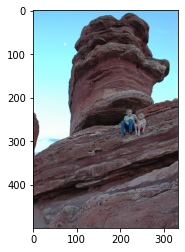

In [ ]:
#Visualize the Results
Test_image_name="976392326_082dafc3c5.jpg"
Test_image_id=Test_image_name.split('.')[0]
image_path=os.path.join(BASE_DIR,"Images",Test_image_name)
print(image_path)
image=Image.open(image_path)
plt.imshow(image)
captions=Mapping[Test_image_id]
print('_______________________Actual_________________')
for caption in captions:
  print(caption)

y_pred=predict_caption(new_model,Img_features[Test_image_id].reshape(1,4096),tokenizer,max_length_cap)
print('_____________________Predicted________________')
print(y_pred)


#Try on Meme images

In [ ]:
Image_dir='/content/drive/MyDrive/Colab Notebooks/hateful_memes/'

In [ ]:
#New dataset
import glob
Test_path=glob.glob('/content/drive/MyDrive/Colab Notebooks/hateful_memes/image_5/*.jpg')
Test_path

['/content/drive/MyDrive/Colab Notebooks/hateful_memes/image_5/img_1.jpg',
 '/content/drive/MyDrive/Colab Notebooks/hateful_memes/image_5/img_2.jpg',
 '/content/drive/MyDrive/Colab Notebooks/hateful_memes/image_5/img_3.jpg',
 '/content/drive/MyDrive/Colab Notebooks/hateful_memes/image_5/img_4.jpg',
 '/content/drive/MyDrive/Colab Notebooks/hateful_memes/image_5/img_5.jpg',
 '/content/drive/MyDrive/Colab Notebooks/hateful_memes/image_5/img_6.jpg',
 '/content/drive/MyDrive/Colab Notebooks/hateful_memes/image_5/img_7.jpg',
 '/content/drive/MyDrive/Colab Notebooks/hateful_memes/image_5/img_8.jpg',
 '/content/drive/MyDrive/Colab Notebooks/hateful_memes/image_5/img_9.jpg',
 '/content/drive/MyDrive/Colab Notebooks/hateful_memes/image_5/img_10.jpg',
 '/content/drive/MyDrive/Colab Notebooks/hateful_memes/image_5/img_13.jpg',
 '/content/drive/MyDrive/Colab Notebooks/hateful_memes/image_5/img_11.jpg',
 '/content/drive/MyDrive/Colab Notebooks/hateful_memes/image_5/img_12.jpg',
 '/content/drive/MyDr

In [ ]:
Test_path='/content/drive/MyDrive/Colab Notebooks/hateful_memes/image_no_caption/img_1.jpg'

In [ ]:
#extract features from image
Test_features={}
#count=0
for img_name in tqdm(Test_path):
 #load the images from Images folder
  img_file=cv2.imread(img_name)
  #resize data for model 
  img_file=cv2.resize(img_file,(224,224))
  #convert the image pixel to a numpy array
  X=image.img_to_array(img_file)
  #Reshape data for preprocess
  X=X.reshape((1,X.shape[0],X.shape[1],X.shape[2]))
  #y_file=np.expand_dims(x_file,axis=0)
  #y_file=x_file.reshape(1,224,224,3)

  #preprocess image for feature extraction
  X=preprocess_input(X)
  #get features
  feature=vgg_model.predict(X,verbose=1).reshape(4096,)
  #Get image ID
  image_id=((os.path.basename(img_name)).split('.')[0])
  
  #Store features
  Test_features[image_id]=feature

  #Only get fix count of data
  #count +=1
  #if count>100:
    #break

  0%|          | 0/15 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


In [ ]:
import cv2
from google.colab.patches import cv2_imshow
for file in Test_path:
  img=cv2.imread(file)
  cv2_imshow(img)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
predicted=[]
#save=pd.DataFrame(columns=['Original Annotations','Predicted captions'])
for key in tqdm(Test_features):
  #pdb.set_trace()
    print('Image_id:',key)
    #get actual caption
    #captions=Mapping[key]
    #print('Original Annotations: ',captions)
    #preict the captiong for image
    y_pred=predict_caption(new_model,Test_features[key].reshape(1,4096),tokenizer,max_length_cap)
    #save.loc[key]=[captions,y_pred]
    print('Predicted caption: ',y_pred)
    #split into words
    #actual_captions=[caption.split() for caption in captions]
    #y_pred=y_pred.split()
    #append to the list
    #actual.append(actual_captions)
    #predicted.append(y_pred)
    

#Calculate BLUE score
#print('BLEU-1: %f' % corpus_bleu(actual,predicted,weights=(1.0,0,0,0)))
#print('BLEU-2: %f' % corpus_bleu(actual,predicted,weights=(0.5,0.5,0,0)))
#print(save)

  0%|          | 0/15 [00:00<?, ?it/s]

Image_id: img_1
Predicted caption:  startseq black dog with blue collar is sitting on top of green grass endseq
Image_id: img_2
Predicted caption:  startseq two women are sitting on the floor under sign endseq
Image_id: img_3
Predicted caption:  startseq two guys are sitting on bench in front of red building endseq
Image_id: img_4
Predicted caption:  startseq man in blue shirt and hat smiles at the camera endseq
Image_id: img_5
Predicted caption:  startseq man with shaved head and hat stands in front of blue and white striped head endseq
Image_id: img_6
Predicted caption:  startseq man wearing tuxedo and hat waves to the camera endseq
Image_id: img_7
Predicted caption:  startseq two women in bikinis stand in front of building endseq
Image_id: img_8
Predicted caption:  startseq two people are sitting on top of war with large rock endseq
Image_id: img_9
Predicted caption:  startseq man in purple shirt and backpack stands on the grass endseq
Image_id: img_10
Predicted caption:  startseq m

/content/drive/MyDrive/Colab Notebooks/hateful_memes/image_5/img_2.jpg
_____________________Predicted________________
startseq two women are sitting on the floor under sign endseq


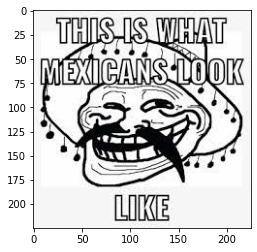

In [ ]:
#Visualize the Results
Test_image_name="img_2.jpg"
Test_image_id=Test_image_name.split('.')[0]
image_path=os.path.join(Image_dir,"image_5",Test_image_name)
print(image_path)
image=Image.open(image_path)
plt.imshow(image)

y_pred=predict_caption(new_model,Test_features[Test_image_id].reshape(1,4096),tokenizer,max_length_cap)
print('_____________________Predicted________________')
print(y_pred)